# Regression 

## House prices prediction

Link on competition dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Imports

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from getpass import getpass
from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn_pandas import DataFrameMapper, gen_features
from mpl_toolkits import mplot3d

sns.set_context('talk')
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = (10, 8)
# Commonly used constants
SEED = 42
DATA_PATH = Path('./data')
TRAIN_PATH = DATA_PATH / 'train.csv'
TEST_DATA = DATA_PATH / 'test.csv'
TARGET = 'SalePrice'

## Functions

In [3]:
def univariate_regplot(x, y, data):
    ax = sns.regplot(x=x, y=y, data=train)
    ax.set_title(f'{y} and {x} relationship')
    return ax

To download dataset, you can go to Kaggle and download data yourself.

Alternatively, you can use [Kaggle API](https://github.com/Kaggle/kaggle-api) to download it from notebook. 
For that option, please follow commands in cell below.

## Dataset download with Kaggle API

### API credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in the location `~/.kaggle/kaggle.json` (on Windows in the location `C:\Users\<Windows-username>\.kaggle\kaggle.json` - you can check the exact location, sans drive, with `echo %HOMEPATH%`). You can define a shell environment variable `KAGGLE_CONFIG_DIR` to change this location to `$KAGGLE_CONFIG_DIR/kaggle.json` (on Windows it will be `%KAGGLE_CONFIG_DIR%\kaggle.json`).

In [4]:
!pip install --user kaggle

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [5]:
!kaggle datasets download -d house-prices-advanced-regression-techniques -p ./kaggle_data

d:\software\anaconda2\envs\ml\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.18) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Traceback (most recent call last):
  File "d:\software\anaconda2\envs\ml\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\software\anaconda2\envs\ml\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Software\anaconda2\envs\ml\Scripts\kaggle.exe\__main__.py", line 9, in <module>
  File "d:\software\anaconda2\envs\ml\lib\site-packages\kaggle\cli.py", line 46, in main
    out = args.func(**command_args)
  File "d:\software\anaconda2\envs\ml\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 422, in dataset_download_cli
    self.dataset_download_files(dataset, path, force, quiet)
  File "d:\software\anaconda2\envs\ml\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 400, in dataset_download_files
    dataset_slug = da

## EDA

In [4]:
train = pd.read_csv(TRAIN_PATH, index_col=0)
test = pd.read_csv(TEST_DATA, index_col=0)
full = pd.concat([train, test], sort=False)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# categories described as numbers
mssubclass_mapping = {
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45: '1-1/2 STORY - UNFINISHED ALL AGES',
    50: '1-1/2 STORY FINISHED ALL AGES',
    60: '2-STORY 1946 & NEWER',
    70: '2-STORY 1945 & OLDER',
    75: '2-1/2 STORY ALL AGES',
    80: 'SPLIT OR MULTI-LEVEL',
    85: 'SPLIT FOYER',
    90: 'DUPLEX - ALL STYLES AND AGES',
   120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
   150: '1-1/2 STORY PUD - ALL AGES',
   160: '2-STORY PUD - 1946 & NEWER',
   180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
   190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}
mosold_mapping = dict(zip(range(1, 13), ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 
                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

full.loc[:, 'MSSubClass'] = full.MSSubClass.map(mssubclass_mapping)
full.loc[:, 'MoSold'] = full.MoSold.map(mosold_mapping)

In [6]:
# Categories with implied ordering
full.loc[:, 'KitchenQual'] = pd.Categorical(full.KitchenQual, ordered=True, categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'])
full.loc[:, 'OverallQual'] = pd.Categorical(full.OverallQual, ordered=True)
full.loc[:, 'OverallCond'] = pd.Categorical(full.OverallQual, ordered=True)
full.loc[:, 'YearBuilt'] = pd.Categorical(full.YearBuilt, ordered=True)
full.loc[:, 'YearRemodAdd'] = pd.Categorical(full.YearRemodAdd, ordered=True)
full.loc[:, 'MoSold'] = pd.Categorical(full.MoSold, ordered=True)
full.loc[:, 'YrSold'] = pd.Categorical(full.YrSold, ordered=True)
full.loc[:, 'GarageYrBlt'] = pd.Categorical(full.GarageYrBlt, ordered=True)

### Target variable analysis

C:\Users\Admin\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


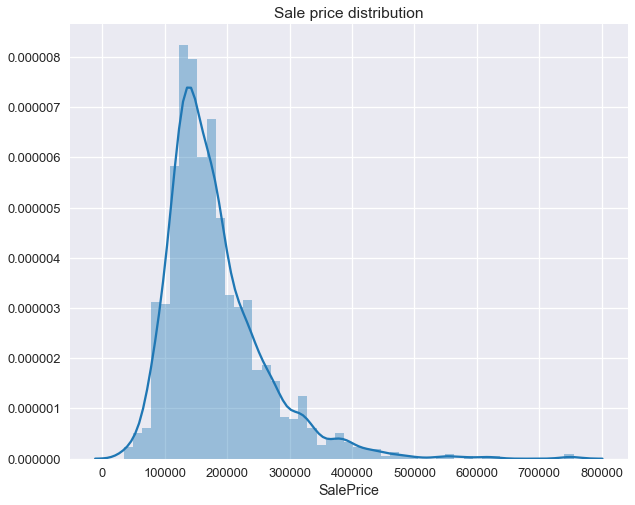

In [7]:
ax = sns.distplot(train.SalePrice, norm_hist=True)
ax.set_title('Sale price distribution');

C:\Users\Admin\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


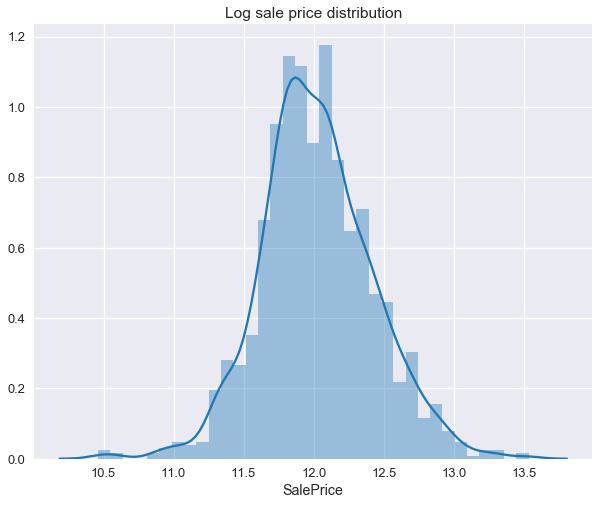

In [8]:
ax = sns.distplot(np.log(train.SalePrice), norm_hist=True)
ax.set_title('Log sale price distribution');

In [11]:
profile = ProfileReport(train)
profile

Number of variables,81
Number of observations,1460
Total Missing (%),5.9%
Total size in memory,924.0 KiB
Average record size in memory,648.1 B
Numeric,38
Categorical,43
Boolean,0
Date,0
Text (Unique),0
Rejected,0


### Top correlated features

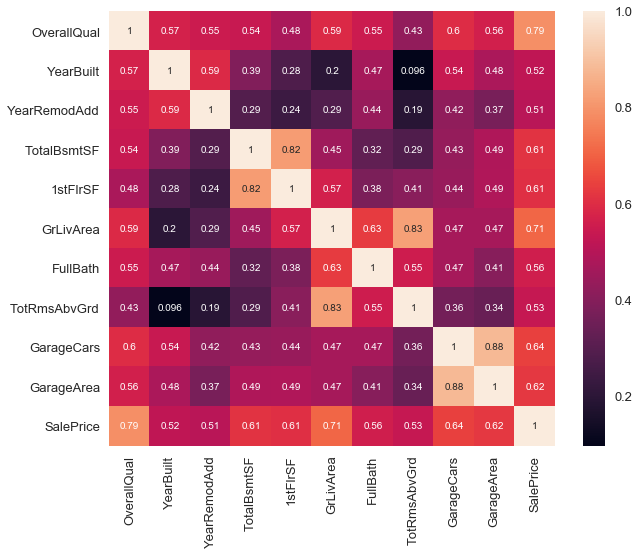

In [9]:
corr = train.corr()
condition = (corr.SalePrice > 0.5) | (corr.SalePrice < -0.5)
top_corr = corr.loc[condition, condition]
sns.heatmap(top_corr, annot=True);

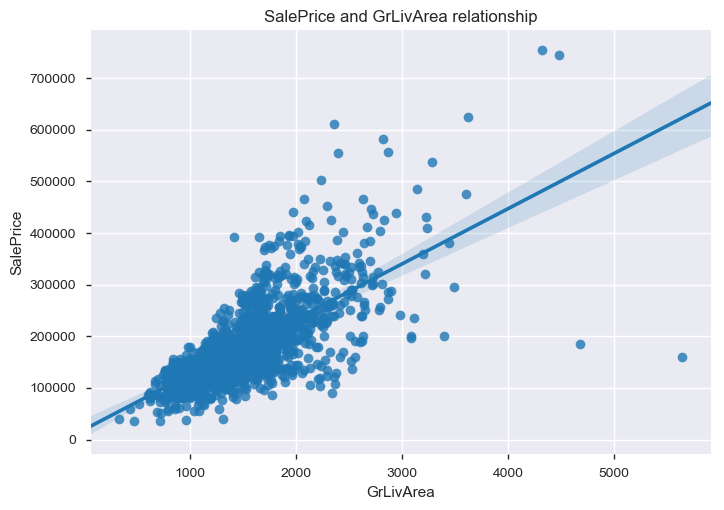

In [13]:
univariate_regplot('GrLivArea', 'SalePrice', train);

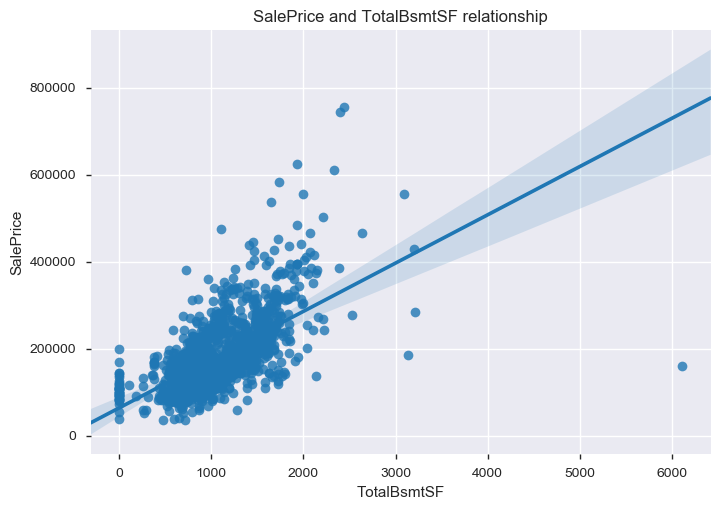

In [14]:
univariate_regplot('TotalBsmtSF', 'SalePrice', train);

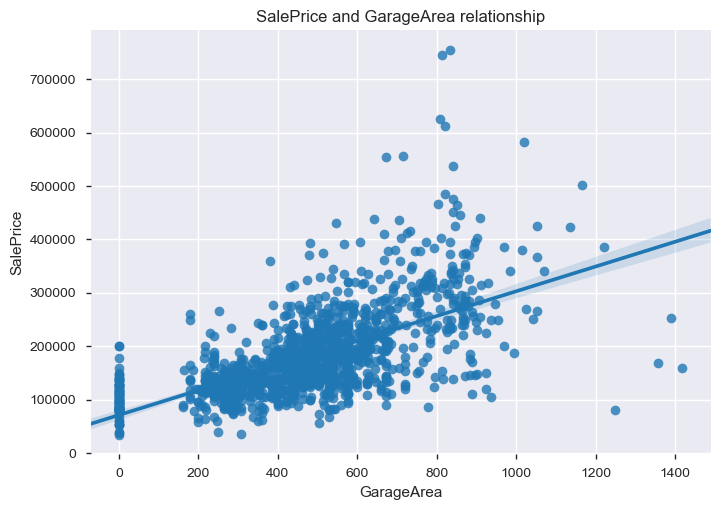

In [15]:
univariate_regplot('GarageArea', 'SalePrice', train);

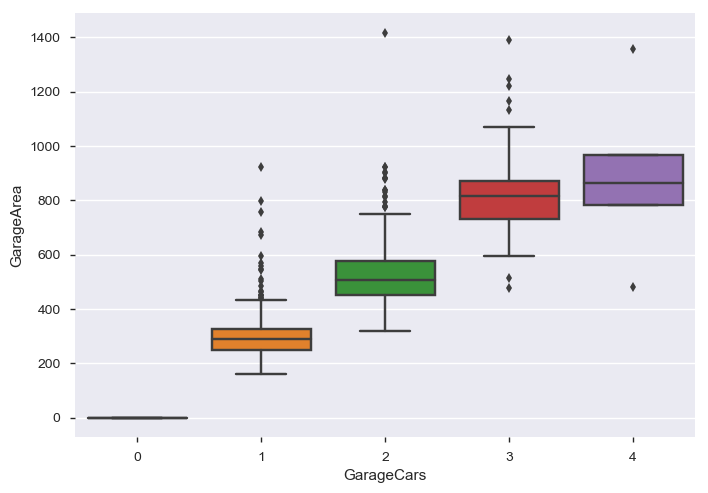

In [16]:
sns.boxplot(y='GarageArea', x='GarageCars', data=train);

# Pipeline

## Features categorization

In [10]:
CATEGORICAL = full.select_dtypes(include=['object']).columns.tolist()
ORDINAL = full.select_dtypes(include=['category']).columns.tolist()
NUMERICAL = full.select_dtypes(exclude=['category', 'object']).columns.tolist()
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [11]:
# Apply encoding to ordinal values 
full[ORDINAL] = full[ORDINAL].apply(lambda x: x.cat.codes)

In [12]:
train = full.loc[full.SalePrice.notnull()]
test = full.loc[full.SalePrice.isnull()]

## Remove obvious outliers

In [13]:
outliers_ind = ((train.SalePrice < 20000) & (train.GrLivArea > 4000))
train = train.loc[~outliers_ind]

## Split

In [14]:
target = train[TARGET].values
train_X, val_X, train_y, val_y = train_test_split(train.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=True)

# Imputing missing values

### Numerical

In [15]:
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': StandardScaler}
    ]
)

In [16]:
numerical_def

[(['LotFrontage'],
  [SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['LotArea'], [SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['MasVnrArea'],
  [SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['BsmtFinSF1'],
  [SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['BsmtFinSF2'],
  [SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='median', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['BsmtUnfSF'], [SimpleImputer(copy=True, fill_value=None, missing_v

### Ordinal

In [17]:
ordinal_def = gen_features(
    columns=[[c] for c in ORDINAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'}
    ]
)

### Categorical

In [18]:
categorical_def = gen_features(
    columns=[[c] for c in CATEGORICAL],
    classes=[
        {'class': OneHotEncoder, 'return_df': False, 'handle_unknown': 'ignore', 'use_cat_names': True}
    ]    
)

## Transformation pipeline

In [19]:
features = numerical_def + categorical_def + ordinal_def
mapper = DataFrameMapper(features, df_out=True)

In [20]:
len(features)

79

## Evaluation pipeline

In [21]:
def evaluate_model(train, val, tr_y, val_y, features, est):
    mapper = DataFrameMapper(features, df_out=True)
    
    train = mapper.fit_transform(train)
    val = mapper.transform(val)
    
    est.fit(train.values, tr_y)
    pred_val = est.predict(val.values)
    pred_train = est.predict(train.values)
    
    
    
    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    }), train.columns    

## Linear regression baseline

In [22]:
reg = LinearRegression()
scores, _ = evaluate_model(train_X, val_X, train_y, val_y, features, reg)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,19576.05865,0.936881,1.342249e+12,-2.571808e+14


**Ex**
Evaluate the same model using $\log(y)$ instead of $y$

In [29]:
reg = LinearRegression()
scores, _ = evaluate_model(train_X, val_X, np.log(train_y + 1), np.log(val_y + 1), features, reg)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.093145,0.943912,1.164180e+07,-7.827081e+14


### Drop some features

**Ex:**

Select only features that have a correlation coefficient with `SalePrice` more than 0.5. 

Remove from the list `GarageArea` feature as it is highly correlated with `GarageCars`

Filter currect feature_definition pipeline and fit the linear regression model only on top correlated features

In [30]:
ind = np.abs(corr[TARGET]) > 0.5
top_corr = corr[TARGET][ind].index.tolist()
top_corr.remove(TARGET)
top_corr.remove('GarageArea')

In [31]:
top_corr

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars']

In [32]:
top_corr_features = [f for f in features if f[0][0] in top_corr]

In [33]:
scores, _ = evaluate_model(train_X, val_X, np.log(train_y + 1), np.log(val_y + 1), top_corr_features, LinearRegression())
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.178132,0.794868,0.166081,0.840706


## Regularization

In [23]:
def plot_importance(est, colnames, top_n=20):
    importance = pd.DataFrame({
        'abs_weight': np.abs(lasso.coef_),
        'feature': colnames
    })
    imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
    sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');

In [24]:
lasso = Lasso(alpha=200)
scores, colnames = evaluate_model(train_X, val_X, train_y, val_y, features, lasso)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,25549.582408,0.892483,28541.786704,0.883712


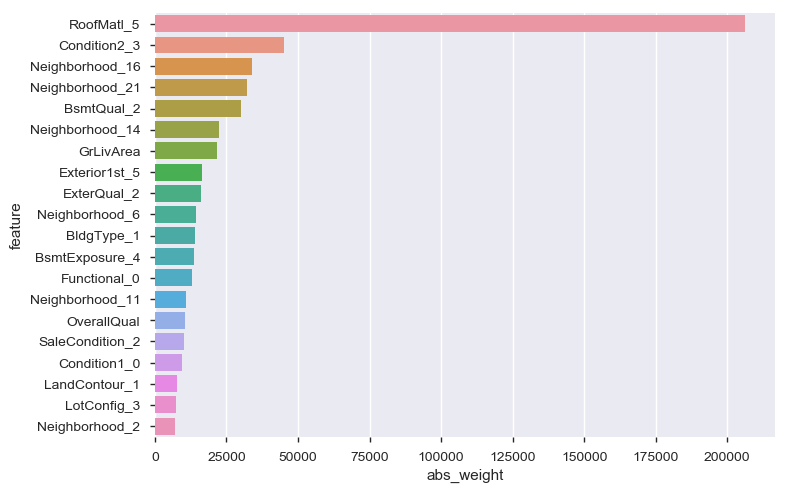

In [36]:
plot_importance(lasso, colnames)

**Ex:**

Show dependency between top 2 features (not encoded) and target variable.

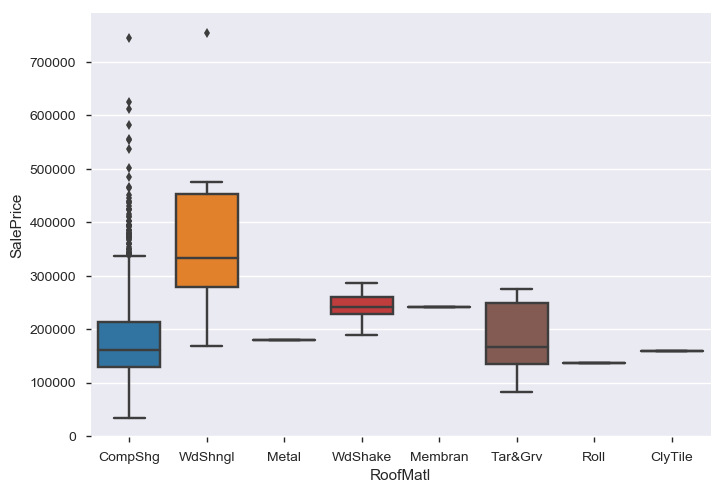

In [37]:
sns.boxplot(x='RoofMatl', y='SalePrice', data=train);

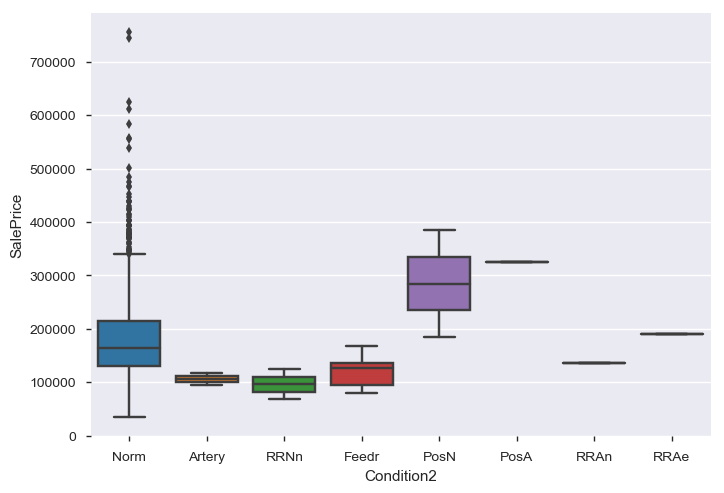

In [38]:
sns.boxplot(x='Condition2', y='SalePrice', data=train);

## Hyperparameters tuning

In [25]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
gs = GridSearchCV(
        ElasticNet(random_state=SEED), 
        {
            'alpha': np.linspace(0, 300, 10),
            'l1_ratio': np.arange(0, 1.1, 0.1)
        }, 
        n_jobs=-1, 
         scoring=['neg_mean_squared_error', 'r2'], 
         refit='neg_mean_squared_error',
         cv=cv, 
         verbose=5
)
mapper = DataFrameMapper(features)
mapped_train_x = mapper.fit_transform(train_X)

In [28]:
pipe = Pipeline([('map', mapper), ('model', ElasticNet(alpha=133.3, l1_ratio=1.0))])

In [26]:
%%time
gs.fit(mapped_train_x, train_y);

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1945s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1976s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:   20.5s
[Parallel(n_jo

Wall time: 35.5 s


[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:   35.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([  0.     ,  33.33333,  66.66667, 100.     , 133.33333, 166.66667,
       200.     , 233.33333, 266.66667, 300.     ]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [41]:
gs.best_params_

{'alpha': 133.33333333333334, 'l1_ratio': 1.0}

In [42]:
scores, col = evaluate_model(train_X, val_X, train_y, val_y, features, ElasticNet(random_state=SEED, **gs.best_params_))
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,23759.848992,0.907019,27731.212595,0.890223


**Ex:**

What will happen, if we use the same parameters, but log(y) for target?

Write the code evaluating model with best parameters. Try to explain results.

In [43]:
elastic = ElasticNet(random_state=SEED, **gs.best_params_)
scores, col = evaluate_model(train_X, val_X, np.log(train_y + 1), np.log(val_y + 1), features, elastic)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.393301,0.0,0.417062,-0.004525


In [44]:
%%time
gs = GridSearchCV(ElasticNet(random_state=SEED), {
    'alpha': np.linspace(0, 0.5, 10),
    'l1_ratio': np.arange(0, 0.5, 0.1)
}, 
                 n_jobs=-1, 
                 scoring=['neg_mean_squared_error', 'r2'], 
                 refit='neg_mean_squared_error',
                 cv=cv, 
                 verbose=10)
gs.fit(mapped_train_x, np.log(train_y + 1))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Wall time: 15.2 s


C:\Users\Rodion_Martynov\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


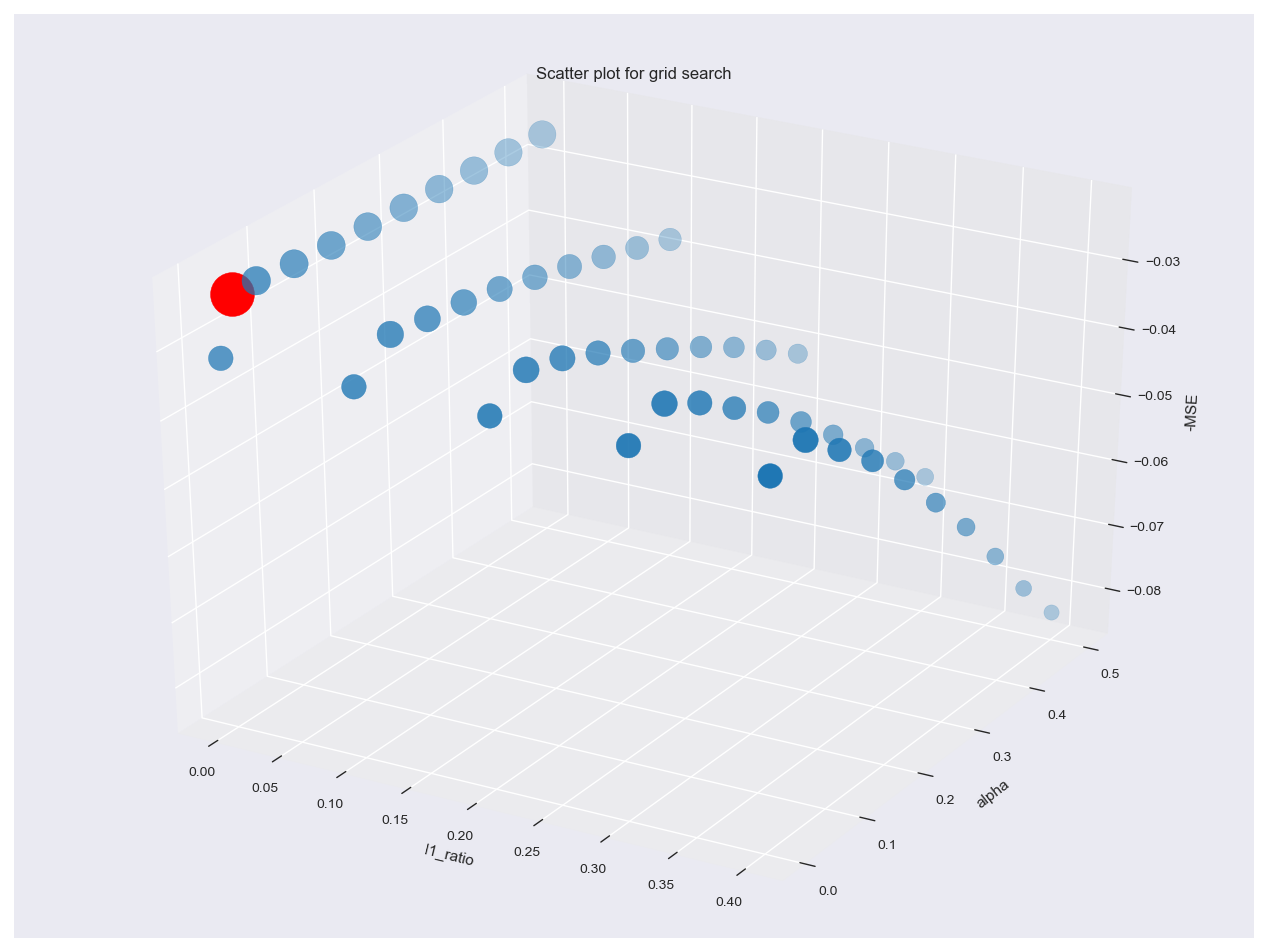

In [45]:
z = gs.cv_results_['mean_test_neg_mean_squared_error']
y = gs.cv_results_['param_alpha'].data.astype(np.float64)
x = gs.cv_results_['param_l1_ratio'].data.astype(np.float64)
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, s=(-10 / z).astype(np.int32))
ax.scatter3D([0], [0.02], [gs.best_score_], s=1000, c='red')
ax.set_xlabel('\nl1_ratio')
ax.set_ylabel('\nalpha')
ax.set_zlabel('\n\n-MSE')
ax.set_title('Scatter plot for grid search');

In [46]:
gs.best_score_

-0.02374380091962235

In [47]:
gs.best_estimator_

ElasticNet(alpha=0.05555555555555555, copy_X=True, fit_intercept=True,
      l1_ratio=0.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=42, selection='cyclic', tol=0.0001,
      warm_start=False)

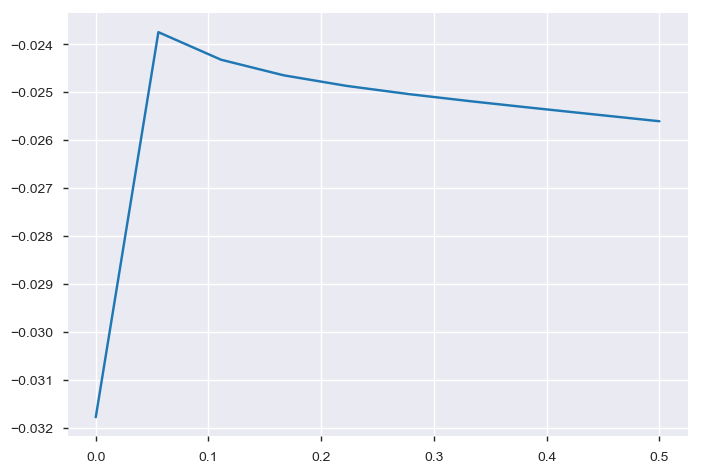

In [48]:
plt.plot(y[x==0], z[x==0]);

In [49]:
scores, col = evaluate_model(train_X, val_X, np.log(train_y + 1), np.log(val_y + 1), 
                             features, Ridge(alpha=gs.best_params_['alpha']))
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.093472,0.943518,0.129639,0.902942
